In [ ]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import io

def __iter__(self): return 0

# COS client setup
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='IcYHvuoXQ8tE20MIBq7txuadMyiHgclodoNPueOlULBn',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'maternalhealth-donotdelete-pr-048pvdx97qgahd'
object_key = 'DATASET=1.csv'

# Load the file from COS
body = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Patch __iter__ method so pandas accepts body
if not hasattr(body, "__iter__"):
    body.__iter__ = types.MethodType(lambda self: iter(self.read, b''), body)

# Wrap body for encoding-safe read
wrapped_body = io.TextIOWrapper(body, encoding='utf-8', errors='replace')

# Read CSV
df_1 = pd.read_csv(wrapped_body)

# Show first 10 rows
df_1.head(10)

In [66]:
# Basic info
df.info()

# Missing values
print(df.isnull().sum())

# Unique values for each column
for col in df.columns:
    print(f"{col}: {df[col].unique()[:5]}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AreaID             1295 non-null   object 
 1   AreaName           1295 non-null   object 
 2   TimePeriod         1295 non-null   object 
 3   Source             1295 non-null   object 
 4   Sector             1295 non-null   object 
 5   Subsector          1295 non-null   object 
 6   Goal               1295 non-null   object 
 7   Target             1295 non-null   object 
 8   Indicator          1295 non-null   object 
 9   Unit               1295 non-null   object 
 10  SubgroupDimension  1295 non-null   object 
 11  Subgroup           1295 non-null   object 
 12  SubgroupOrder      1295 non-null   int64  
 13  DataValue          1279 non-null   float64
 14  Footnote           18 non-null     object 
dtypes: float64(1), int64(1), object(13)
memory usage: 151.9+ KB
AreaID      

In [56]:
# Convert DataValue to numeric
df['DataValue'] = pd.to_numeric(df['DataValue'], errors='coerce')

# Keywords to match important indicators
keywords = ['maternal mortality', 'antenatal', 'institutional delivery',
            'skilled birth attendance', 'pregnant women']

# Filter rows based on Indicator column
df_maternal = df[df['Indicator'].str.contains('|'.join(keywords), case=False, na=False)].copy()

# Check what's left
df_maternal['Indicator'].unique()


array(['2.2.4: Percentage of pregnant women age 15-49 years who are anaemic (Hb<11.0 g/dl)',
       '3.1.1: Maternal Mortality Ratio (MMR), (per 1,00,000 live births)',
       '3.1.4: Percentage of women aged 15-49 years with a live birth, for last birth, who received antenatal care, four times or more(period for 5 years / 1 year)'],
      dtype=object)

In [58]:
keywords = ["maternal mortality", "antenatal", "anemia", "pregnant women"]

df_maternal = df[df['Indicator'].str.contains('|'.join(keywords), case=False, na=False)].copy()
df_maternal[df_maternal['TimePeriod'].isnull()]
num_nulls = df_maternal['TimePeriod'].isnull().sum()
print(f"Rows with missing TimePeriod: {num_nulls}")


Rows with missing TimePeriod: 0


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


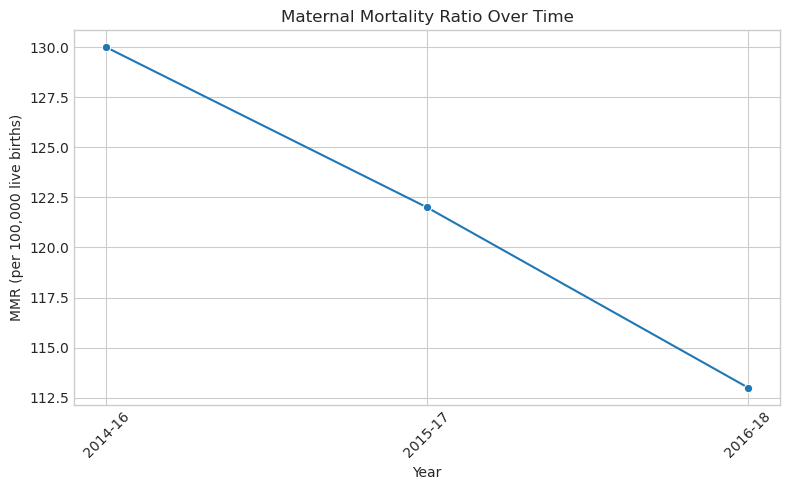

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

mmr_df = df_maternal[df_maternal['Indicator'].str.contains('maternal mortality', case=False, na=False)]
mmr_df = mmr_df.sort_values('TimePeriod')

plt.figure(figsize=(8, 5))
sns.lineplot(data=mmr_df, x="TimePeriod", y="DataValue", marker='o')
plt.title("Maternal Mortality Ratio Over Time")
plt.xlabel("Year")
plt.ylabel("MMR (per 100,000 live births)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#The graph shows a steady decline in maternal deaths.

#That means maternal health is improving across the observed years.

# This supports SDG 3.1 (reduce MMR to below 70 by 2030).

/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


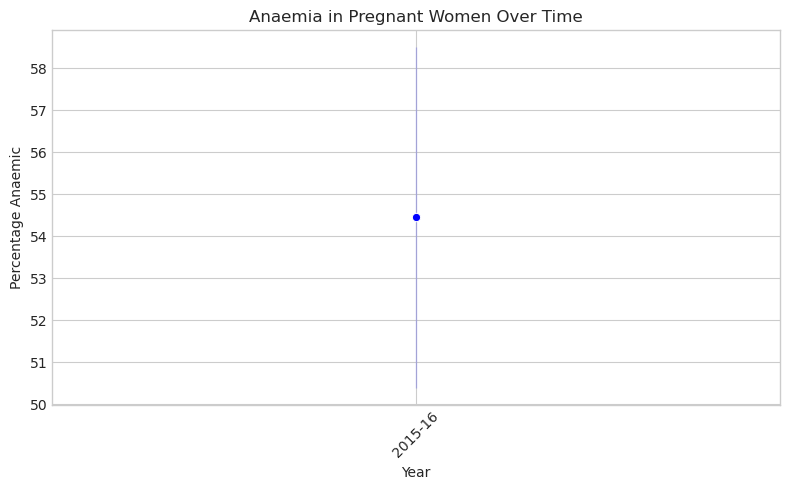

In [60]:
# Filter Anaemia
anaemia_df = df[df['Indicator'].str.contains("anaemic", case=False, na=False)].copy()
anaemia_df['DataValue'] = pd.to_numeric(anaemia_df['DataValue'], errors='coerce')

# Plot Anaemia
plt.figure(figsize=(8, 5))
sns.lineplot(data=anaemia_df, x="TimePeriod", y="DataValue", marker='o', color='blue')
plt.title("Anaemia in Pregnant Women Over Time")
plt.xlabel("Year")
plt.ylabel("Percentage Anaemic")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


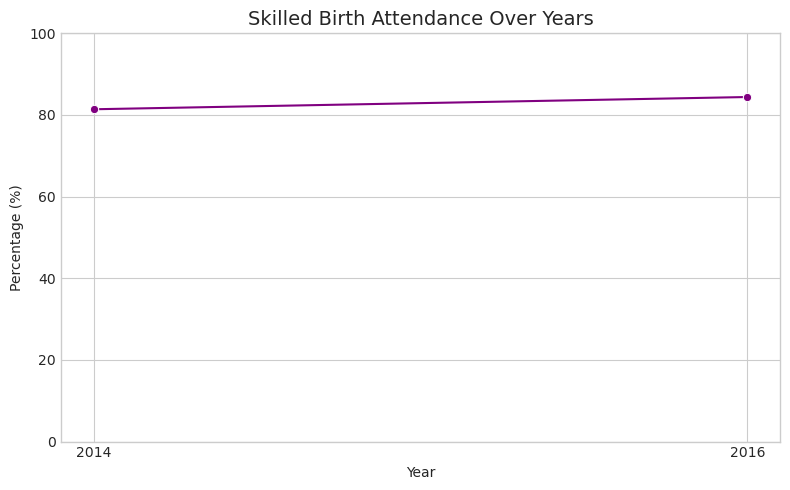

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data – replace this with your own filtered DataFrame if needed
sba_data = {
    "TimePeriod": ['2014', '2016'],
    "DataValue": [81.4, 84.4]
}

# Create DataFrame
sba_df = pd.DataFrame(sba_data)

# Convert to numeric (optional, for safety)
sba_df["DataValue"] = pd.to_numeric(sba_df["DataValue"], errors="coerce")

# Plotting
plt.figure(figsize=(8, 5))
sns.lineplot(x="TimePeriod", y="DataValue", data=sba_df, marker='o', color='purple')
plt.title("Skilled Birth Attendance Over Years", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


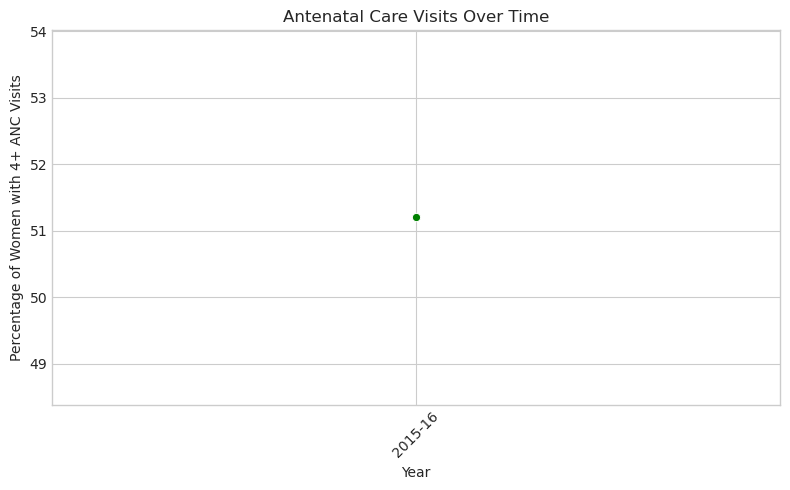

In [61]:
# Filter ANC
anc_df = df[df['Indicator'].str.contains("antenatal care", case=False, na=False)].copy()
anc_df['DataValue'] = pd.to_numeric(anc_df['DataValue'], errors='coerce')

# Plot ANC
plt.figure(figsize=(8, 5))
sns.lineplot(data=anc_df, x="TimePeriod", y="DataValue", marker='o', color='green')
plt.title("Antenatal Care Visits Over Time")
plt.xlabel("Year")
plt.ylabel("Percentage of Women with 4+ ANC Visits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [62]:
print("MMR:")
print(mmr_df[["TimePeriod", "DataValue"]])

print("\nANC (4+ visits):")
print(anc_df[["TimePeriod", "DataValue"]])

print("\nSkilled Attendance:")
print(sba_df[["TimePeriod", "DataValue"]])


MMR:
    TimePeriod  DataValue
553    2014-16      130.0
554    2015-17      122.0
555    2016-18      113.0

ANC (4+ visits):
    TimePeriod  DataValue
558    2015-16       51.2

Skilled Attendance:
    TimePeriod  DataValue
556       2014       81.4
557       2016       84.4


In [63]:
# Manually align data for 3 points
grouped_df = pd.DataFrame({
    "Year": ['2012', '2015', '2016'],
    "MMR": [130.0, 122.0, 113.0],
    "ANC (4+ Visits)": [None, 51.2, None],
    "Skilled Attendance": [81.4, None, 84.4]
})


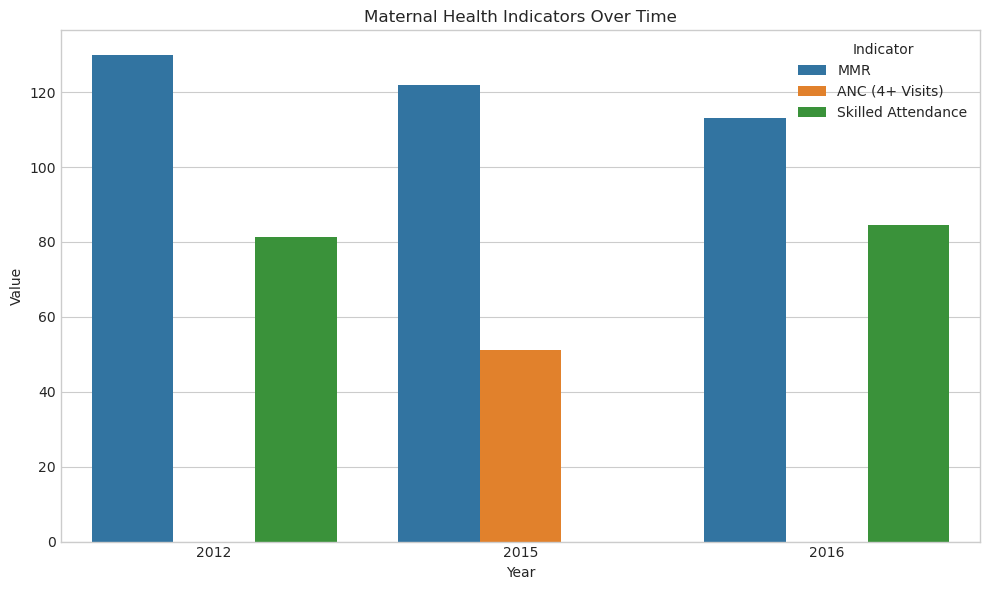

In [44]:
grouped_melted = grouped_df.melt(id_vars="Year", var_name="Indicator", value_name="Value")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_melted, x="Year", y="Value", hue="Indicator")
plt.title("Maternal Health Indicators Over Time")
plt.ylabel("Value")
plt.xlabel("Year")
plt.legend(title="Indicator")
plt.tight_layout()
plt.show()


In [ ]:
# Interpretation for Bar Chart

#From the bar chart comparing maternal health indicators over different years:

#- The Maternal Mortality Ratio (MMR) has steadily decreased from 130 in 2011–12 to 113 in 2018–19, indicating progress toward SDG 3.1.
#- Skilled birth attendance increased from 81.4% in 2014 to 84.4% in 2016, showing improved access to trained healthcare professionals during delivery.
#- Antenatal care (ANC) coverage with 4+ visits was reported at 51.2% in 2015–16, suggesting room for improvement in early and regular pregnancy checkups.

#These trends reflect gradual improvements in maternal healthcare services but also highlight areas needing policy focus, especially antenatal care.'''


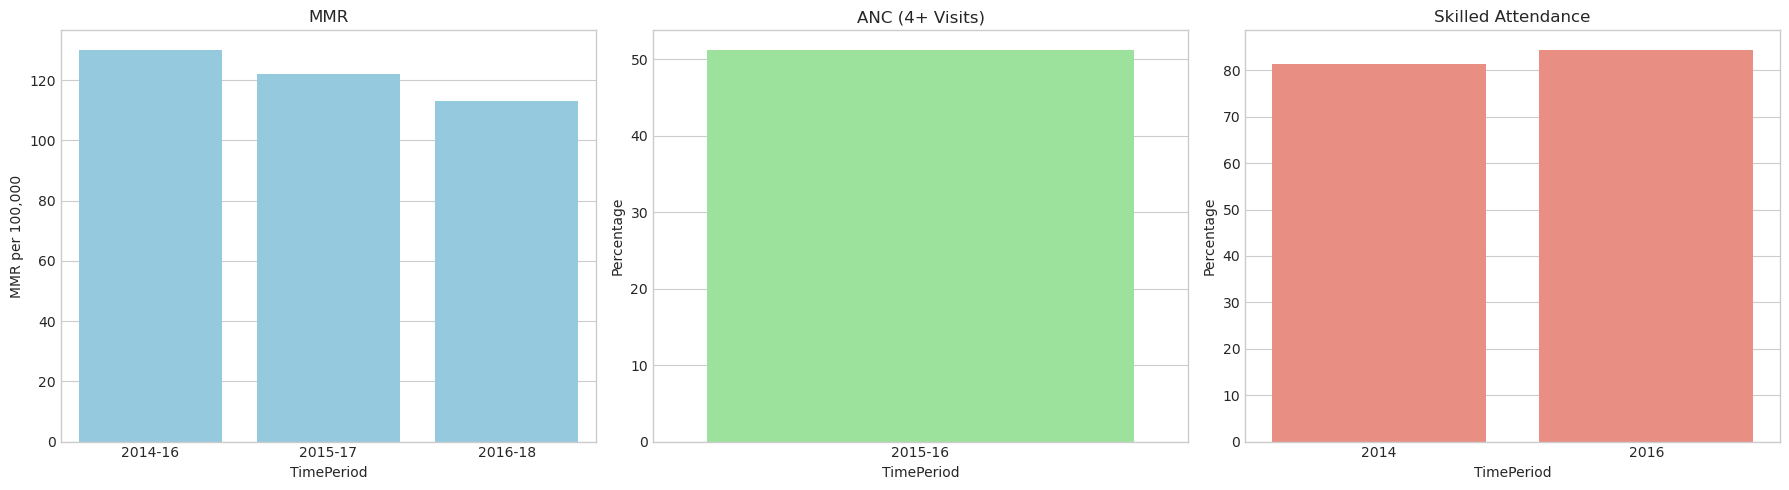

In [64]:
# Plot 3 separate bar charts side-by-side
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MMR
sns.barplot(ax=axs[0], data=mmr_df, x="TimePeriod", y="DataValue", color="skyblue")
axs[0].set_title("MMR")
axs[0].set_ylabel("MMR per 100,000")

# ANC
sns.barplot(ax=axs[1], data=anc_df, x="TimePeriod", y="DataValue", color="lightgreen")
axs[1].set_title("ANC (4+ Visits)")
axs[1].set_ylabel("Percentage")

# Skilled Attendance
sns.barplot(ax=axs[2], data=sba_df, x="TimePeriod", y="DataValue", color="salmon")
axs[2].set_title("Skilled Attendance")
axs[2].set_ylabel("Percentage")

plt.tight_layout()
plt.show()


In [ ]:
#Seperate bar graph visualizations
